## Import Library

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import label_binarize

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Config

#### Implement model

In [31]:
class PhoBertIntentsRecognition(nn.Module):
    def __init__(self):
        super(PhoBertIntentsRecognition, self).__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = torch.nn.Dropout(p=0.3)
        self.linear = nn.Linear(768, 9)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.phobert(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

#### Implement data loader

In [32]:
class IntentsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text_clean'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

#### Implement evaluator

In [33]:
class IntentsPhoBERTEvaluator:
    def __init__(self, model_path):
        self.model = self._load_model(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
        self.test_batch_size = 16
        self.max_len = 128
        self.target_list = ['view_menu', 'view_cart', 'add_to_cart', 'remove_from_cart', 'modify_cart_item', 
                            'confirm_order', 'track_order', 'cancel_order', 'provide_info']
    
    def _load_model(self, model_path):
        model = PhoBertIntentsRecognition()
        model.load_state_dict(torch.load(model_path))
        return model.to(device)
    
    def get_predictions(self, test_data_path):
        df_test = pd.read_excel(test_data_path).fillna(0)
        test_data = IntentsDataset(df_test, self.tokenizer, self.max_len, self.target_list)
        test_data_loader = DataLoader(test_data,
            batch_size=self.test_batch_size,
            shuffle=False,
            num_workers=0
        )
        
        model = self.model.eval()

        titles = []
        predictions = []
        prediction_probs = []
        target_values = []

        with torch.no_grad():
            for data in test_data_loader:
                title = data["title"]
                ids = data["input_ids"].to(device, dtype = torch.long)
                mask = data["attention_mask"].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data["targets"].to(device, dtype = torch.float)

                outputs = model(ids, mask, token_type_ids)
                outputs = torch.sigmoid(outputs).detach().cpu()
                preds = outputs.round()
                targets = targets.detach().cpu()

                titles.extend(title)
                predictions.extend(preds)
                prediction_probs.extend(outputs)
                target_values.extend(targets)

        predictions = torch.stack(predictions)
        prediction_probs = torch.stack(prediction_probs)
        target_values = torch.stack(target_values)

        return titles, predictions, prediction_probs, target_values
    
    def calculate_accuracy(self, predictions, target_values):
        predictions_np = predictions.numpy()
        target_values_np = target_values.numpy()
        
        preds_classes = predictions_np.argmax(axis=1)
        targets_classes = target_values_np.argmax(axis=1)
        
        return accuracy_score(targets_classes, preds_classes)
    
    def print_classification_report(self, predictions, target_values):
        print(classification_report(target_values, predictions, target_names=self.target_list))

    def plot_confusion_matrix(self, predictions, target_values, chart_title):
        predictions_np = predictions.numpy()
        target_values_np = target_values.numpy()

        cm = confusion_matrix(target_values_np.argmax(axis=1), predictions_np.argmax(axis=1), labels=range(len(self.target_list)))
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.target_list, yticklabels=self.target_list)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix of ' + chart_title)
        plt.show()

    def plot_roc_auc(self, prediction_probs, target_values, chart_title):
        prediction_probs_np = prediction_probs.numpy()
        target_values_np = target_values.numpy()
        
        target_values_bin = label_binarize(target_values_np.argmax(axis=1), classes=range(len(self.target_list)))
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(len(self.target_list)):
            fpr[i], tpr[i], _ = roc_curve(target_values_bin[:, i], prediction_probs_np[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 8))
        for i in range(len(self.target_list)):
            plt.plot(fpr[i], tpr[i], label=f'ROC curve for {self.target_list[i]} (area = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("ROC/AUC of " + chart_title)
        plt.legend(loc='lower right')
        plt.show()

## Evaluation

#### Case 1: Data which is 100% generated by ChatGPT 3.5

In [34]:
case_1_model = IntentsPhoBERTEvaluator("../output/savedmodels/intents_100_chatgpt.bin")

In [35]:
case_1_gpt_titles, case_1_gpt_predictions, case_1_gpt_prediction_probs, case_1_gpt_target_values = case_1_model.get_predictions("../data/labeled/intent/intents_test_gpt.xlsx")
case_1_human_titles, case_1_human_predictions, case_1_human_prediction_probs, case_1_human_target_values = case_1_model.get_predictions("../data/labeled/intent/intents_test_human.xlsx")

In [36]:
case_1_gpt_test_accuracy = case_1_model.calculate_accuracy(case_1_gpt_predictions, case_1_gpt_target_values)
case_1_human_test_accuracy = case_1_model.calculate_accuracy(case_1_human_predictions, case_1_human_target_values)
print("Accuracy on ChatGPT generated testing dataset: ", round(case_1_gpt_test_accuracy * 100, 2))
print("Accuracy on human written testing dataset: ", round(case_1_human_test_accuracy * 100, 2))

Accuracy on ChatGPT generated testing dataset:  96.47
Accuracy on human written testing dataset:  82.41


In [37]:
print("Classification report on ChatGPT generated testing dataset:")
case_1_model.print_classification_report(case_1_gpt_predictions, case_1_gpt_target_values)

print("Classification report on Human written testing dataset:")
case_1_model.print_classification_report(case_1_human_predictions, case_1_human_target_values)

Classification report on ChatGPT generated testing dataset:
                  precision    recall  f1-score   support

       view_menu       1.00      1.00      1.00       162
       view_cart       0.93      0.95      0.94        99
     add_to_cart       0.96      0.98      0.97       163
remove_from_cart       0.96      0.98      0.97        82
modify_cart_item       0.99      0.96      0.97       140
   confirm_order       0.94      0.97      0.96       124
     track_order       0.95      0.94      0.95       154
    cancel_order       0.99      0.99      0.99       137
    provide_info       0.94      0.96      0.95        99

       micro avg       0.97      0.97      0.97      1160
       macro avg       0.96      0.97      0.97      1160
    weighted avg       0.97      0.97      0.97      1160
     samples avg       0.97      0.97      0.97      1160

Classification report on Human written testing dataset:
                  precision    recall  f1-score   support

       vie

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


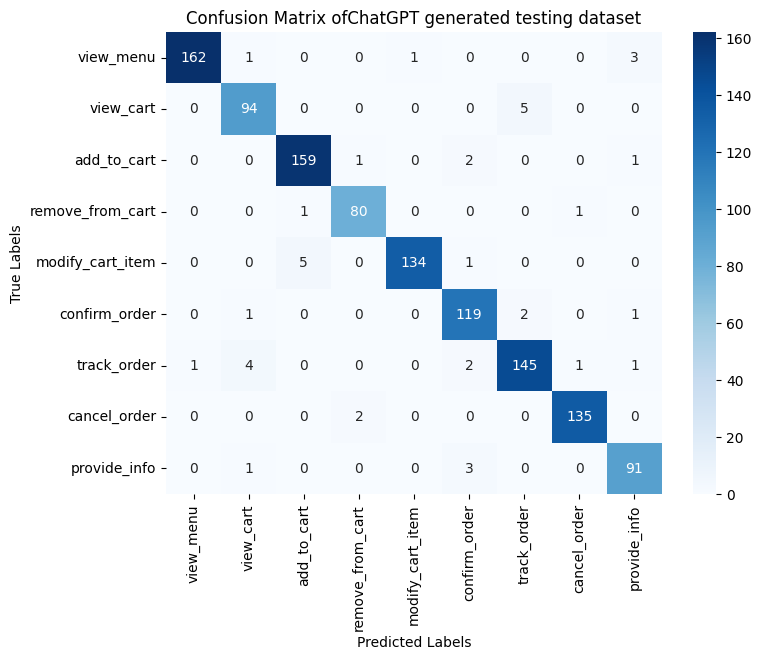

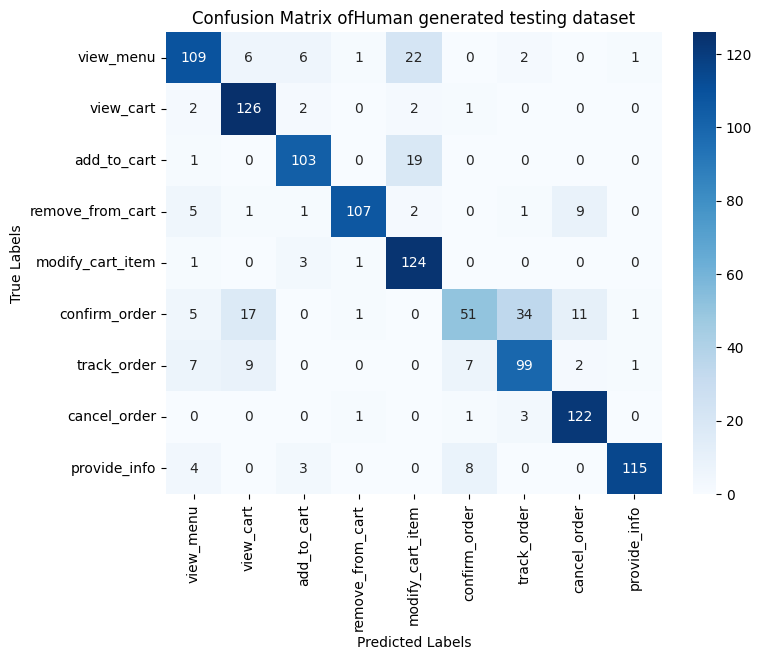

In [38]:
case_1_model.plot_confusion_matrix(case_1_gpt_predictions, case_1_gpt_target_values, "ChatGPT generated testing dataset")
case_1_model.plot_confusion_matrix(case_1_human_predictions, case_1_human_target_values, "Human generated testing dataset")

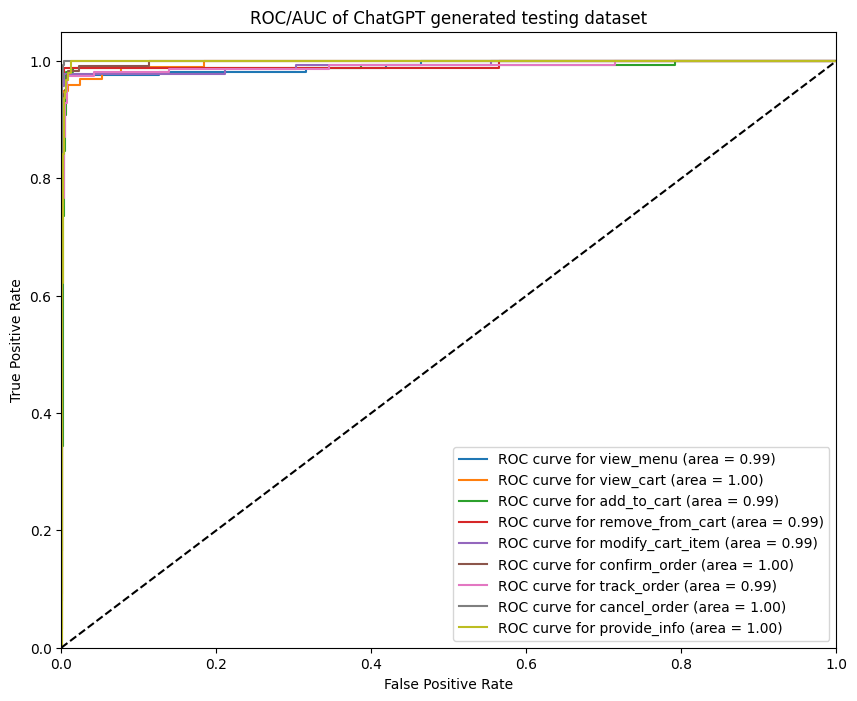

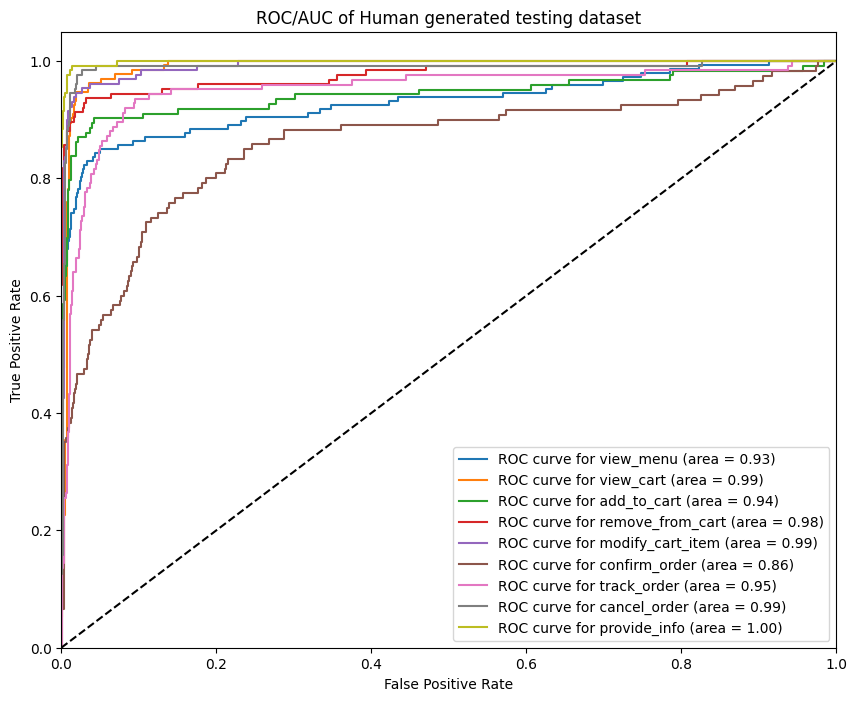

In [39]:
case_1_model.plot_roc_auc(case_1_gpt_prediction_probs, case_1_gpt_target_values, "ChatGPT generated testing dataset")
case_1_model.plot_roc_auc(case_1_human_prediction_probs, case_1_human_target_values, "Human generated testing dataset")

#### Case 2: Data which is 100% written by human

In [40]:
case_2_model = IntentsPhoBERTEvaluator("../output/savedmodels/intents_100_human.bin")

In [41]:
case_2_gpt_titles, case_2_gpt_predictions, case_2_gpt_prediction_probs, case_2_gpt_target_values = case_2_model.get_predictions("../data/labeled/intent/intents_test_gpt.xlsx")
case_2_human_titles, case_2_human_predictions, case_2_human_prediction_probs, case_2_human_target_values = case_2_model.get_predictions("../data/labeled/intent/intents_test_human.xlsx")

In [42]:
case_2_gpt_test_accuracy = case_2_model.calculate_accuracy(case_2_gpt_predictions, case_2_gpt_target_values)
case_2_human_test_accuracy = case_2_model.calculate_accuracy(case_2_human_predictions, case_2_human_target_values)
print("Accuracy on ChatGPT generated testing dataset: ", round(case_2_gpt_test_accuracy * 100, 2))
print("Accuracy on human written testing dataset: ", round(case_2_human_test_accuracy * 100, 2))

Accuracy on ChatGPT generated testing dataset:  93.79
Accuracy on human written testing dataset:  97.76


In [43]:
print("Classification report on ChatGPT generated testing dataset:")
case_2_model.print_classification_report(case_2_gpt_predictions, case_2_gpt_target_values)

print("Classification report on Human written testing dataset:")
case_2_model.print_classification_report(case_2_human_predictions, case_2_human_target_values)

Classification report on ChatGPT generated testing dataset:
                  precision    recall  f1-score   support

       view_menu       0.98      0.99      0.98       162
       view_cart       0.96      0.91      0.93        99
     add_to_cart       0.98      0.77      0.86       163
remove_from_cart       0.99      0.99      0.99        82
modify_cart_item       0.80      0.99      0.89       140
   confirm_order       0.96      0.94      0.95       124
     track_order       0.91      0.97      0.94       154
    cancel_order       0.99      0.99      0.99       137
    provide_info       0.92      0.94      0.93        99

       micro avg       0.94      0.94      0.94      1160
       macro avg       0.94      0.94      0.94      1160
    weighted avg       0.94      0.94      0.94      1160
     samples avg       0.94      0.94      0.94      1160

Classification report on Human written testing dataset:
                  precision    recall  f1-score   support

       vie

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


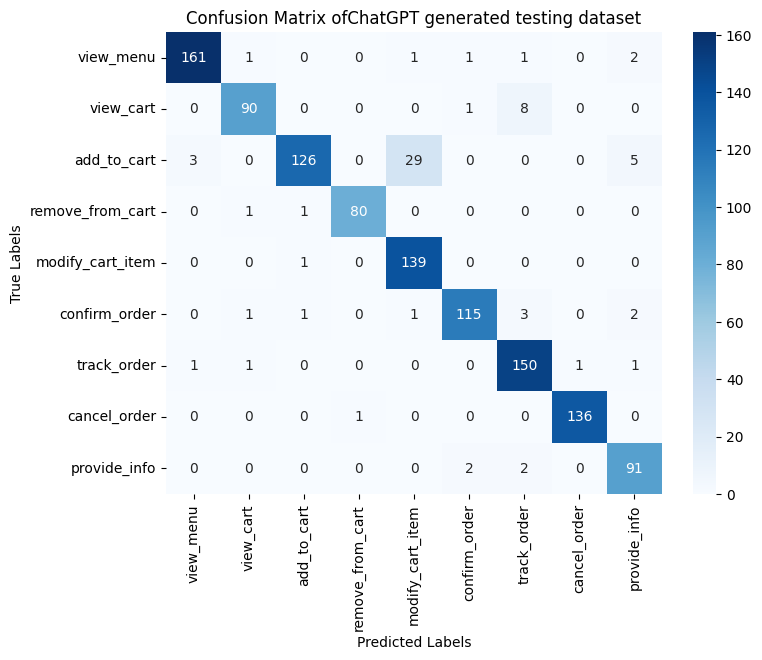

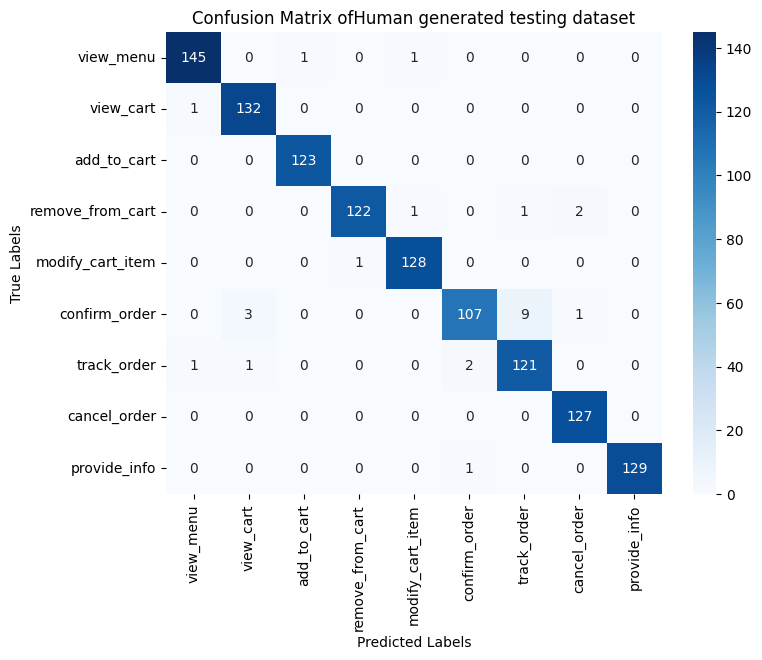

In [44]:
case_2_model.plot_confusion_matrix(case_2_gpt_predictions, case_2_gpt_target_values, "ChatGPT generated testing dataset")
case_2_model.plot_confusion_matrix(case_2_human_predictions, case_2_human_target_values, "Human generated testing dataset")

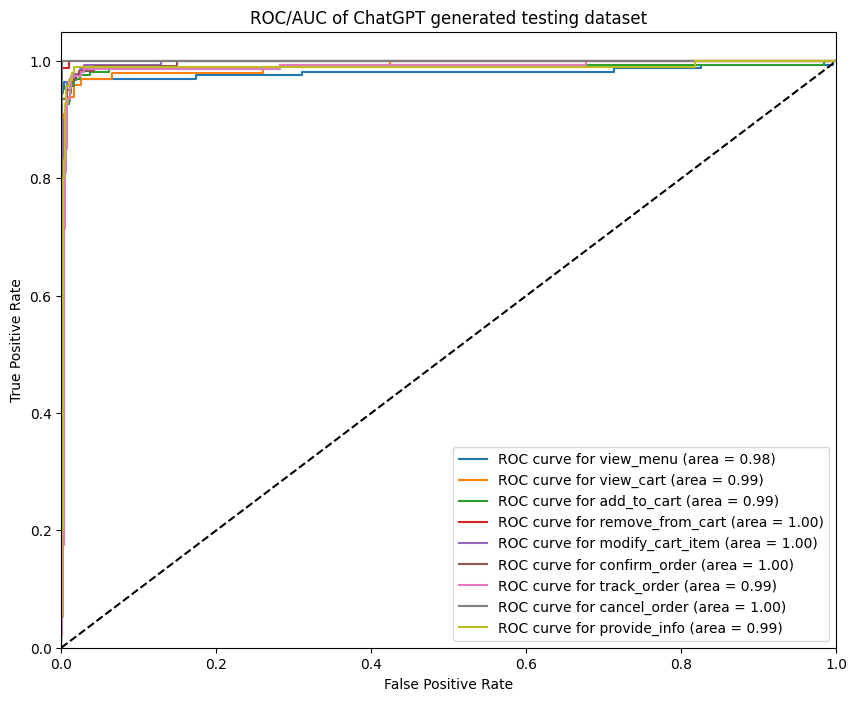

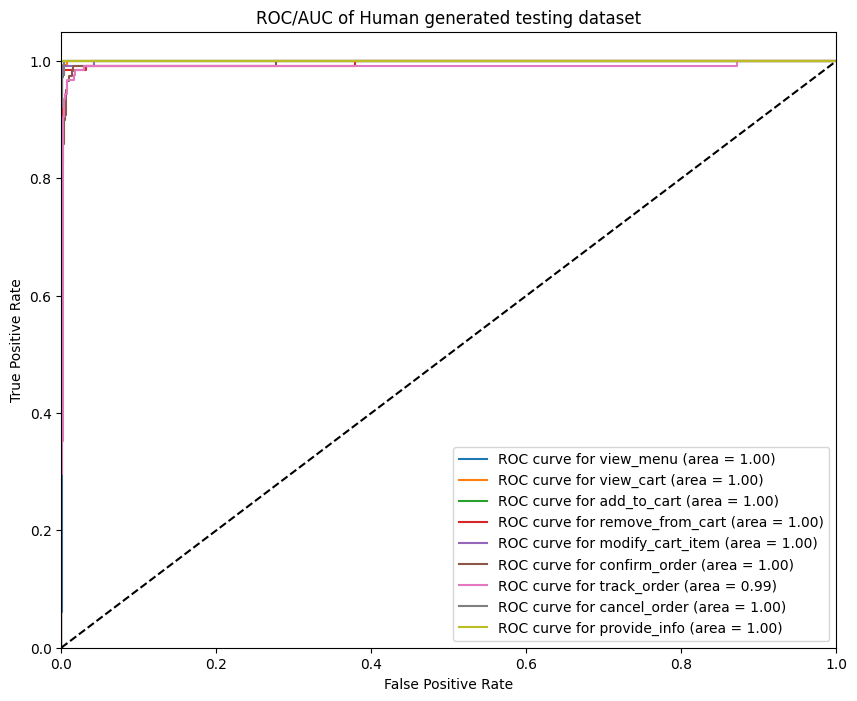

In [45]:
case_2_model.plot_roc_auc(case_2_gpt_prediction_probs, case_2_gpt_target_values, "ChatGPT generated testing dataset")
case_2_model.plot_roc_auc(case_2_human_prediction_probs, case_2_human_target_values, "Human generated testing dataset")

#### Case 3: Combined data which is aggregated from 2 previous sources in 50-50 ratio

In [46]:
case_3_model = IntentsPhoBERTEvaluator("../output/savedmodels/intents_50_chatgpt_50_human.bin")

In [47]:
case_3_gpt_titles, case_3_gpt_predictions, case_3_gpt_prediction_probs, case_3_gpt_target_values = case_3_model.get_predictions("../data/labeled/intent/intents_test_gpt.xlsx")
case_3_human_titles, case_3_human_predictions, case_3_human_prediction_probs, case_3_human_target_values = case_3_model.get_predictions("../data/labeled/intent/intents_test_human.xlsx")

In [48]:
case_3_gpt_test_accuracy = case_3_model.calculate_accuracy(case_3_gpt_predictions, case_3_gpt_target_values)
case_3_human_test_accuracy = case_3_model.calculate_accuracy(case_3_human_predictions, case_3_human_target_values)
print("Accuracy on ChatGPT generated testing dataset: ", round(case_3_gpt_test_accuracy * 100, 2))
print("Accuracy on human written testing dataset: ", round(case_3_human_test_accuracy * 100, 2))

Accuracy on ChatGPT generated testing dataset:  96.03
Accuracy on human written testing dataset:  99.57


In [49]:
print("Classification report on ChatGPT generated testing dataset:")
case_3_model.print_classification_report(case_3_gpt_predictions, case_3_gpt_target_values)

print("Classification report on Human written testing dataset:")
case_3_model.print_classification_report(case_3_human_predictions, case_3_human_target_values)

Classification report on ChatGPT generated testing dataset:
                  precision    recall  f1-score   support

       view_menu       1.00      0.99      0.99       162
       view_cart       0.91      0.97      0.94        99
     add_to_cart       0.96      0.95      0.96       163
remove_from_cart       0.99      0.95      0.97        82
modify_cart_item       0.99      0.96      0.97       140
   confirm_order       0.94      0.98      0.96       124
     track_order       0.97      0.93      0.95       154
    cancel_order       0.99      0.99      0.99       137
    provide_info       0.97      0.97      0.97        99

       micro avg       0.97      0.96      0.97      1160
       macro avg       0.97      0.96      0.97      1160
    weighted avg       0.97      0.96      0.97      1160
     samples avg       0.96      0.96      0.96      1160

Classification report on Human written testing dataset:
                  precision    recall  f1-score   support

       vie

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


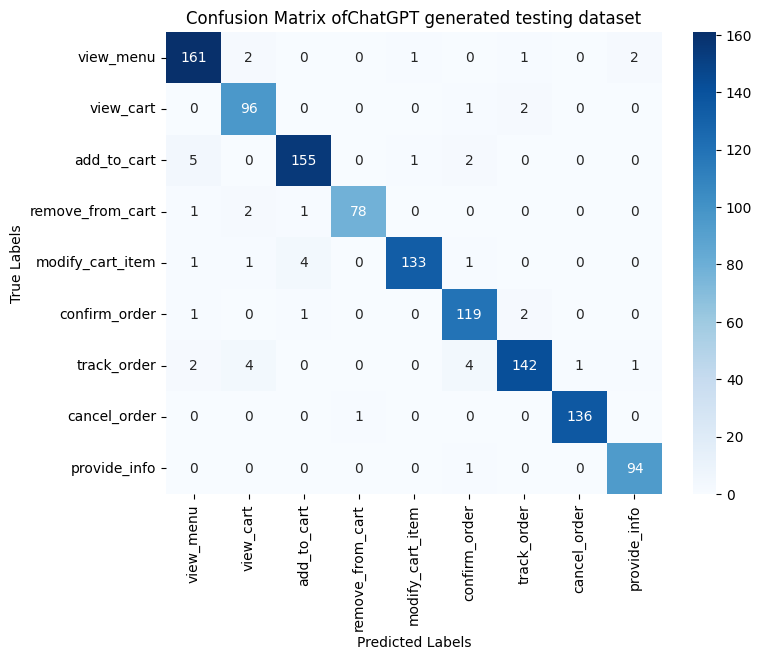

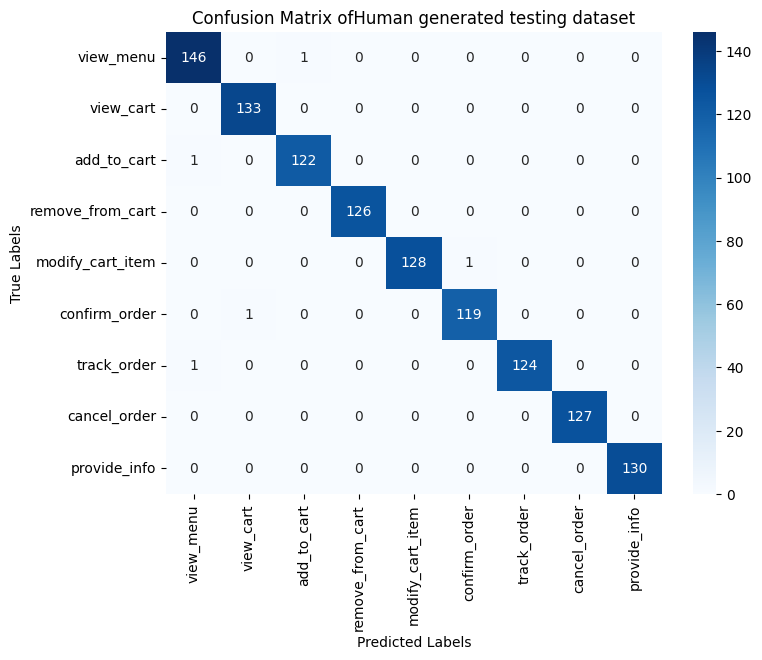

In [50]:
case_3_model.plot_confusion_matrix(case_3_gpt_predictions, case_3_gpt_target_values, "ChatGPT generated testing dataset")
case_3_model.plot_confusion_matrix(case_3_human_predictions, case_3_human_target_values, "Human generated testing dataset")

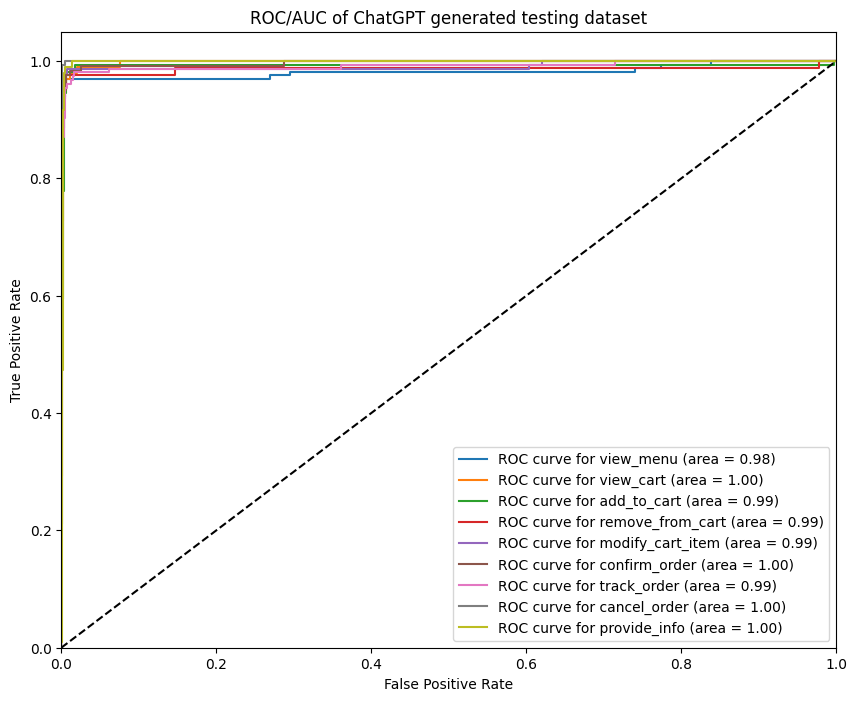

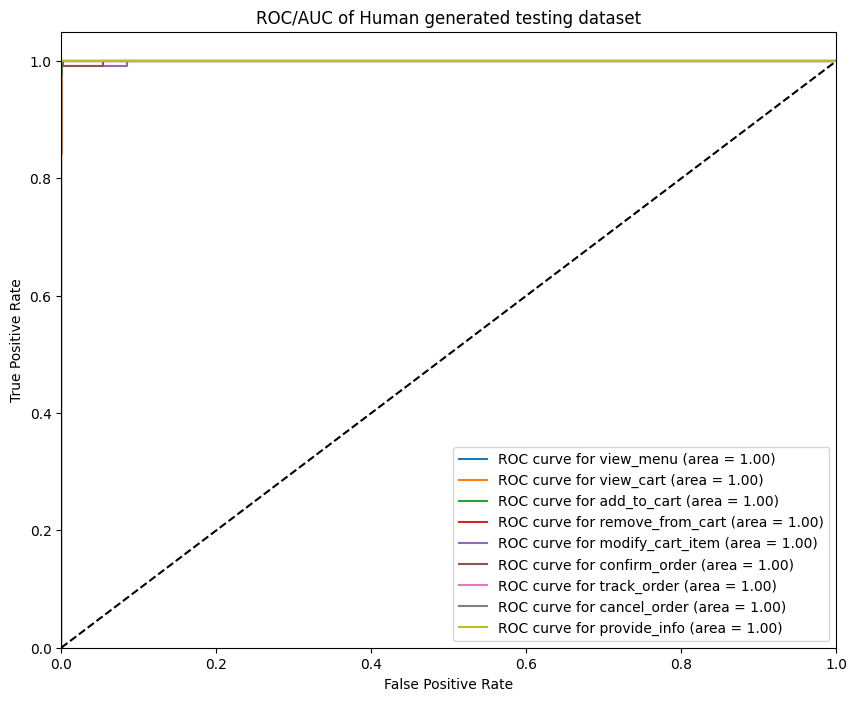

In [51]:
case_3_model.plot_roc_auc(case_3_gpt_prediction_probs, case_3_gpt_target_values, "ChatGPT generated testing dataset")
case_3_model.plot_roc_auc(case_3_human_prediction_probs, case_3_human_target_values, "Human generated testing dataset")